#### Step 1: Load the Data

In [1]:
import pandas as pd
import json

# Load data from the JSON file
data = []
with open('clean_trips.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)


#### Step 2: Feature Engineering

In [3]:
from geopy.distance import geodesic
import numpy as np
from sklearn.cluster import KMeans

def feature_engineering(df):
    # Calculate cumulative distance
    def calculate_cumulative_distance(lats, lngs):
        cumulative_distance = [0.0]
        for i in range(1, len(lats)):
            start = (lats[i-1], lngs[i-1])
            end = (lats[i], lngs[i])
            dist = geodesic(start, end).kilometers
            cumulative_distance.append(cumulative_distance[-1] + dist)
        return cumulative_distance

    df['cumulative_distance'] = df.apply(lambda row: calculate_cumulative_distance(row['lats'], row['lngs']), axis=1)

    # Calculate segmented speeds
    def calculate_segmented_speeds(cumulative_distance, time_gap):
        speeds = []
        for i in range(1, len(cumulative_distance)):
            distance_diff = cumulative_distance[i] - cumulative_distance[i-1]
            time_diff = time_gap[i] - time_gap[i-1]
            if time_diff != 0:
                speed = distance_diff / (time_diff / 3600)  # speed in km/h
            else:
                speed = 0  # or some other handling mechanism
            speeds.append(speed)
        speeds.insert(0, 0.0)  # Insert 0.0 speed for the first element as there's no previous segment
        return speeds

    df['segmented_speeds'] = df.apply(lambda row: calculate_segmented_speeds(row['cumulative_distance'], row['time_gap']), axis=1)

    # Extract temporal features
    df['time_of_day'] = df['timeID'] % 24
    df['day_of_week'] = df['dateID'] % 7

    # Cluster routes
    def cluster_routes(lats, lngs, num_clusters=5):
        coords = np.array(list(zip(lats, lngs)))
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
        return kmeans.labels_

    df['route_cluster'] = df.apply(lambda row: cluster_routes(row['lats'], row['lngs']), axis=1)

    # Calculate distance and time differences
    df['distance_diff'] = df['dist_gap'].apply(lambda x: np.diff([0] + x).tolist())
    df['time_diff'] = df['time_gap'].apply(lambda x: np.diff([0] + x).tolist())

    # Calculate average speed over the entire trip
    df['average_speed'] = df['dist'] / (df['time'] / 3600)  # speed in km/h

    return df

# Apply feature engineering
df = feature_engineering(df)

C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwa

#### Step 3: Split the Data

In [4]:
from sklearn.model_selection import train_test_split

# Define features and target variable
features = ['cumulative_distance', 'segmented_speeds', 'time_of_day', 'day_of_week', 'route_cluster', 'distance_diff', 'time_diff', 'average_speed']
X = df[features]
y = df['time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Step 4: Train the Random Forest Regressor Model

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rfr = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rfr.fit(X_train, y_train)


ValueError: setting an array element with a sequence.

#### Step 5: Evaluate the Model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the test set
y_pred = rfr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')


#### Step 7: Make Predictions and Calculate Errors

In [ ]:
def estimations(test_data, model):
    test_data['trip_time_estimate'] = model.predict(test_data.drop(columns=['trip_time']))
    test_data['error'] = test_data['trip_time'] - test_data['trip_time_estimate']
    test_data = test_data.query("error < 3600")
    return test_data

plot_df = estimations(df.loc[X_test.index], model)

# Plotting and metrics functions can be reused as is
plot_graphs(plot_df)
get_metrics(plot_df)
# # Example new data
# new_data = {
#     "trip_id": "example_trip_id",
#     "time_gap": [0.0, 10.0, 20.0, ...],  # truncated for brevity
#     "dist": 8.5,
#     "lats": [31.955, 31.956, ...],  # truncated for brevity
#     "lngs": [35.855, 35.856, ...],  # truncated for brevity
#     "driverID": "example_driver_id",
#     "weekID": 2,
#     "timeID": 348,
#     "dateID": 30,
#     "time": 1600
# }

# new_df = pd.DataFrame([new_data])
# new_df = feature_engineering(new_df)

# # Extracting same features
# new_df['avg_segmented_speed'] = new_df['segmented_speeds'].apply(np.mean)
# new_df['avg_distance_diff'] = new_df['distance_diff'].apply(np.mean)
# new_df['avg_time_diff'] = new_df['time_diff'].apply(np.mean)

# new_X = new_df[features]

# # Making prediction
# new_y_pred = rfr.predict(new_X)
# print(f'Predicted ETA: {new_y_pred[0]}')

In [2]:
import pandas as pd
import json
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data from the JSON file
data = []
with open('clean_trips.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to calculate cumulative distance
def calculate_cumulative_distance(lats, lngs):
    cumulative_distance = [0.0]
    for i in range(1, len(lats)):
        start = (lats[i-1], lngs[i-1])
        end = (lats[i], lngs[i])
        dist = geodesic(start, end).kilometers
        cumulative_distance.append(cumulative_distance[-1] + dist)
    return cumulative_distance

# Function to calculate segmented speeds
def calculate_segmented_speeds(cumulative_distance, time_gap):
    speeds = []
    for i in range(1, len(cumulative_distance)):
        distance_diff = cumulative_distance[i] - cumulative_distance[i-1]
        time_diff = time_gap[i] - time_gap[i-1]
        if time_diff != 0:
            speed = distance_diff / (time_diff / 3600)  # speed in km/h
        else:
            speed = 0  # or some other handling mechanism
        speeds.append(speed)
    speeds.insert(0, 0.0)  # Insert 0.0 speed for the first element as there's no previous segment
    return speeds

# Function to find indices with zero time differences
def find_zero_time_diff_indices(time_gap):
    time_diffs = np.diff(time_gap)
    zero_diff_indices = np.where(time_diffs == 0)[0]  # Get indices where time_diff is zero
    return zero_diff_indices.tolist()

# Apply feature engineering
def feature_engineering(df):
    df['cumulative_distance'] = df.apply(lambda row: calculate_cumulative_distance(row['lats'], row['lngs']), axis=1)
    df['segmented_speeds'] = df.apply(lambda row: calculate_segmented_speeds(row['cumulative_distance'], row['time_gap']), axis=1)
    df['zero_time_diff_indices'] = df['time_gap'].apply(find_zero_time_diff_indices)
    
    # Extracting statistical features from lists
    df['avg_segmented_speed'] = df['segmented_speeds'].apply(np.mean)
    df['max_segmented_speed'] = df['segmented_speeds'].apply(np.max)
    df['min_segmented_speed'] = df['segmented_speeds'].apply(np.min)
    df['std_segmented_speed'] = df['segmented_speeds'].apply(np.std)
    
    df['avg_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.mean(np.diff(x)))
    df['max_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.max(np.diff(x)))
    df['min_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.min(np.diff(x)))
    df['std_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.std(np.diff(x)))
    
    # df['time_of_day'] = df['timeID'] % 24
    df['time_of_day'] = df['timeID'] // 60
    df['day_of_week'] = df['dateID'] % 7
    
    # Calculate average speed over the entire trip
    df['average_speed'] = df['dist'] / (df['time'] / 3600)  # speed in km/h
    
    return df

df = feature_engineering(df)

# Define features and target variable
features = [
    'avg_segmented_speed', 'max_segmented_speed', 'min_segmented_speed', 'std_segmented_speed',
    'avg_distance_diff', 'max_distance_diff', 'min_distance_diff', 'std_distance_diff',
    'time_of_day', 'day_of_week', 'average_speed'
]
X = df[features]
y = df['time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rfr = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rfr.fit(X_train, y_train)

# Predict on the test set
y_pred = rfr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Select an example from the test set for prediction
example_index = X_test.index[0]
example_X = X_test.loc[example_index]
example_y_true = y_test.loc[example_index]

# Make prediction
example_y_pred = rfr.predict([example_X])[0]

print(f'Example trip ID: {df.loc[example_index, "trip_id"]}')
print(f'Predicted ETA: {example_y_pred}')
print(f'Actual ETA: {example_y_true}')


Mean Absolute Error (MAE): 477.29067447916657
Root Mean Squared Error (RMSE): 613.2115054320388
R-squared (R2): 0.2352909898810619
Example trip ID: c565ddbb674fb8382bae1fbbcc47d7bdf6e33d91c8eb0beda3fddbb2c6074640
Predicted ETA: 1741.48
Actual ETA: 1036.0


C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [3]:
import pandas as pd
import json
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import time

# Start timing the script
start_time = time.time()

# Load data from the JSON file
data = []
with open('clean_trips.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to calculate cumulative distance
def calculate_cumulative_distance(lats, lngs):
    cumulative_distance = [0.0]
    for i in range(1, len(lats)):
        start = (lats[i-1], lngs[i-1])
        end = (lats[i], lngs[i])
        dist = geodesic(start, end).kilometers
        cumulative_distance.append(cumulative_distance[-1] + dist)
    return cumulative_distance

# Function to calculate segmented speeds
def calculate_segmented_speeds(cumulative_distance, time_gap):
    speeds = []
    for i in range(1, len(cumulative_distance)):
        distance_diff = cumulative_distance[i] - cumulative_distance[i-1]
        time_diff = time_gap[i] - time_gap[i-1]
        if time_diff != 0:
            speed = distance_diff / (time_diff / 3600)  # speed in km/h
        else:
            speed = 0  # or some other handling mechanism
        speeds.append(speed)
    speeds.insert(0, 0.0)  # Insert 0.0 speed for the first element as there's no previous segment
    return speeds

# Function to find indices with zero time differences
def find_zero_time_diff_indices(time_gap):
    time_diffs = np.diff(time_gap)
    zero_diff_indices = np.where(time_diffs == 0)[0]  # Get indices where time_diff is zero
    return zero_diff_indices.tolist()

# Apply feature engineering
def feature_engineering(df):
    df['cumulative_distance'] = df.apply(lambda row: calculate_cumulative_distance(row['lats'], row['lngs']), axis=1)
    df['segmented_speeds'] = df.apply(lambda row: calculate_segmented_speeds(row['cumulative_distance'], row['time_gap']), axis=1)
    df['zero_time_diff_indices'] = df['time_gap'].apply(find_zero_time_diff_indices)
    
    # Extracting statistical features from lists
    df['avg_segmented_speed'] = df['segmented_speeds'].apply(np.mean)
    df['max_segmented_speed'] = df['segmented_speeds'].apply(np.max)
    df['min_segmented_speed'] = df['segmented_speeds'].apply(np.min)
    df['std_segmented_speed'] = df['segmented_speeds'].apply(np.std)
    
    df['avg_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.mean(np.diff(x)))
    df['max_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.max(np.diff(x)))
    df['min_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.min(np.diff(x)))
    df['std_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.std(np.diff(x)))
    
    df['time_of_day'] = df['timeID'] // 60  # Convert minutes to hours
    df['day_of_week'] = df['dateID'] % 7
    
    # Calculate average speed over the entire trip
    df['average_speed'] = df['dist'] / (df['time'] / 3600)  # speed in km/h
    
    return df

df = feature_engineering(df)

# Define features and target variable
features = [
    'avg_segmented_speed', 'max_segmented_speed', 'min_segmented_speed', 'std_segmented_speed',
    'avg_distance_diff', 'max_distance_diff', 'min_distance_diff', 'std_distance_diff',
    'time_of_day', 'day_of_week', 'average_speed'
]
X = df[features]
y = df['time']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the model
rfr = RandomForestRegressor(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_rfr = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rfr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Select an example from the test set for prediction
example_index = X_test.index[0]
example_X = X_test[example_index]
example_y_true = y_test.iloc[example_index]

# Make prediction
example_y_pred = best_rfr.predict([example_X])[0]

print(f'Example trip ID: {df.loc[example_index, "trip_id"]}')
print(f'Predicted ETA: {example_y_pred}')
print(f'Actual ETA: {example_y_true}')

# Plotting the learning curve
train_sizes, train_scores, test_scores = learning_curve(best_rfr, X_scaled, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting actual vs predicted values
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# End timing the script
end_time = time.time()
print(f'Total script runtime: {end_time - start_time} seconds')


Fitting 3 folds for each of 108 candidates, totalling 324 fits


Mean Absolute Error (MAE): 477.5900651041667
Root Mean Squared Error (RMSE): 614.7461567777626
R-squared (R2): 0.2314586083753588
Example trip ID: 0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
1    0016d7b5510107039e65db431a77047ccd381c975ac910...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
0    0012cf835ee80e59fefbe618282b2edc082940ddba6a46...
Name: trip_id, dtype: object
Predicted ETA: 1705.23
Actual ETA: 1036.0


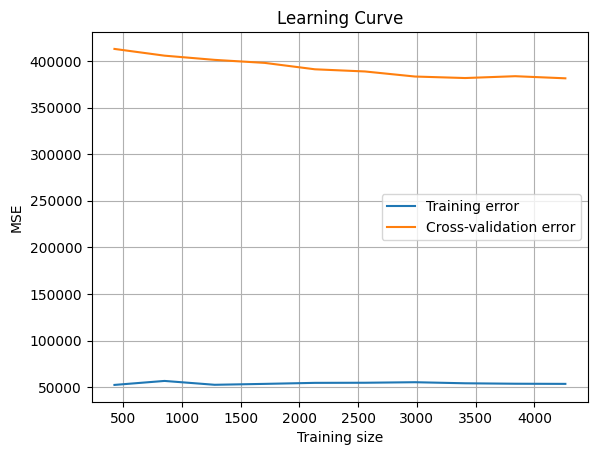

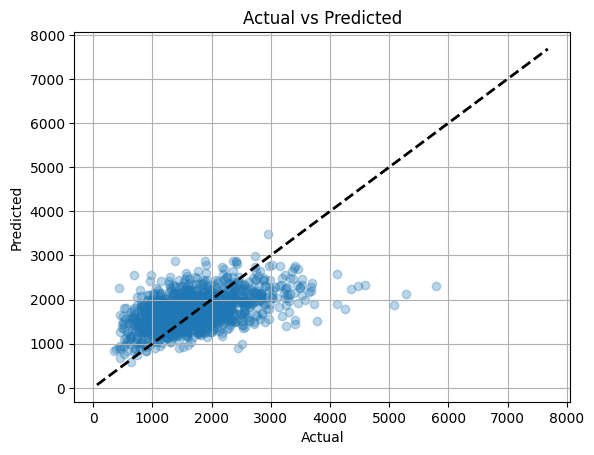

Total script runtime: 276.9670808315277 seconds


In [1]:
import pandas as pd
import json
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import time

# Start timing the script
start_time = time.time()

# Load data from the JSON file
data = []
with open('clean_trips.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to calculate cumulative distance
def calculate_cumulative_distance(lats, lngs):
    cumulative_distance = [0.0]
    for i in range(1, len(lats)):
        start = (lats[i-1], lngs[i-1])
        end = (lats[i], lngs[i])
        dist = geodesic(start, end).kilometers
        cumulative_distance.append(cumulative_distance[-1] + dist)
    return cumulative_distance

# Function to calculate segmented speeds
def calculate_segmented_speeds(cumulative_distance, time_gap):
    speeds = []
    for i in range(1, len(cumulative_distance)):
        distance_diff = cumulative_distance[i] - cumulative_distance[i-1]
        time_diff = time_gap[i] - time_gap[i-1]
        if time_diff != 0:
            speed = distance_diff / (time_diff / 3600)  # speed in km/h
        else:
            speed = 0  # or some other handling mechanism
        speeds.append(speed)
    speeds.insert(0, 0.0)  # Insert 0.0 speed for the first element as there's no previous segment
    return speeds

# Function to find indices with zero time differences
def find_zero_time_diff_indices(time_gap):
    time_diffs = np.diff(time_gap)
    zero_diff_indices = np.where(time_diffs == 0)[0]  # Get indices where time_diff is zero
    return zero_diff_indices.tolist()

# Apply feature engineering
def feature_engineering(df):
    df['cumulative_distance'] = df.apply(lambda row: calculate_cumulative_distance(row['lats'], row['lngs']), axis=1)
    df['segmented_speeds'] = df.apply(lambda row: calculate_segmented_speeds(row['cumulative_distance'], row['time_gap']), axis=1)
    df['zero_time_diff_indices'] = df['time_gap'].apply(find_zero_time_diff_indices)
    
    # Extracting statistical features from lists
    df['avg_segmented_speed'] = df['segmented_speeds'].apply(np.mean)
    df['max_segmented_speed'] = df['segmented_speeds'].apply(np.max)
    df['min_segmented_speed'] = df['segmented_speeds'].apply(np.min)
    df['std_segmented_speed'] = df['segmented_speeds'].apply(np.std)
    
    df['avg_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.mean(np.diff(x)))
    df['max_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.max(np.diff(x)))
    df['min_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.min(np.diff(x)))
    df['std_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.std(np.diff(x)))
    
    df['time_of_day'] = df['timeID'] // 60  # Convert minutes to hours
    df['day_of_week'] = df['dateID'] % 7
    
    # Calculate average speed over the entire trip
    df['average_speed'] = df['dist'] / (df['time'] / 3600)  # speed in km/h
    
    return df

df = feature_engineering(df)

# Define features and target variable
features = [
    'avg_segmented_speed', 'max_segmented_speed', 'min_segmented_speed', 'std_segmented_speed',
    'avg_distance_diff', 'max_distance_diff', 'min_distance_diff', 'std_distance_diff',
    'time_of_day', 'day_of_week', 'average_speed'
]
X = df[features]
y = df['time']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the model with specified hyperparameters
rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    random_state=42,
    criterion='squared_error'
)

# Train the model
rfr.fit(X_train, y_train)

# Predict on the test set
y_pred = rfr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Select an example from the test set for prediction
example_index = X_test[0]
example_y_true = y_test.iloc[0]

# Make prediction
example_y_pred = rfr.predict([example_index])[0]

print(f'Example trip ID: {df.iloc[example_index].trip_id}')
print(f'Predicted ETA: {example_y_pred}')
print(f'Actual ETA: {example_y_true}')

# Plotting the learning curve
train_sizes, train_scores, test_scores = learning_curve(rfr, X_scaled, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting actual vs predicted values
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# End timing the script
end_time = time.time()
print(f'Total script runtime: {end_time - start_time} seconds')


Mean Absolute Error (MAE): 477.5900651041667
Root Mean Squared Error (RMSE): 614.7461567777626
R-squared (R2): 0.2314586083753588
Example trip ID: c565ddbb674fb8382bae1fbbcc47d7bdf6e33d91c8eb0beda3fddbb2c6074640
Predicted ETA: 1705.23
Actual ETA: 1036.0


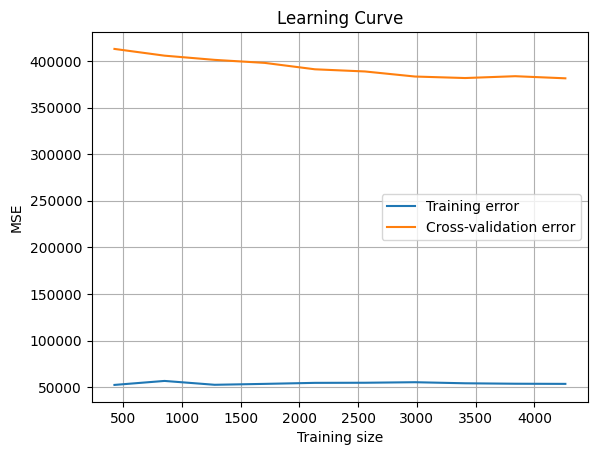

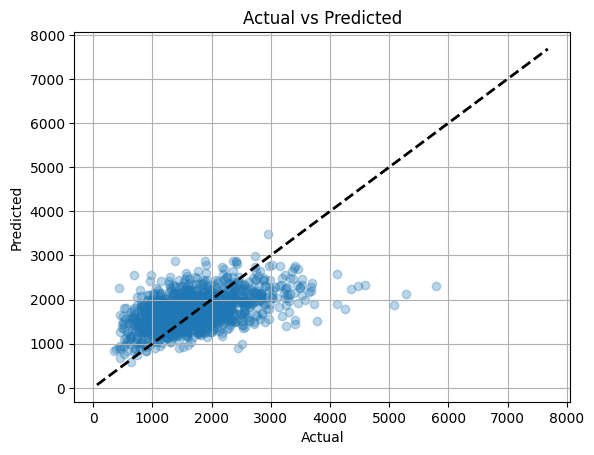

Total script runtime: 235.06475400924683 seconds


In [2]:
import pandas as pd
import json
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import time

# Start timing the script
start_time = time.time()

# Load data from the JSON file
data = []
with open('clean_trips.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to calculate cumulative distance
def calculate_cumulative_distance(lats, lngs):
    cumulative_distance = [0.0]
    for i in range(1, len(lats)):
        start = (lats[i-1], lngs[i-1])
        end = (lats[i], lngs[i])
        dist = geodesic(start, end).kilometers
        cumulative_distance.append(cumulative_distance[-1] + dist)
    return cumulative_distance

# Function to calculate segmented speeds
def calculate_segmented_speeds(cumulative_distance, time_gap):
    speeds = []
    for i in range(1, len(cumulative_distance)):
        distance_diff = cumulative_distance[i] - cumulative_distance[i-1]
        time_diff = time_gap[i] - time_gap[i-1]
        if time_diff != 0:
            speed = distance_diff / (time_diff / 3600)  # speed in km/h
        else:
            speed = 0  # or some other handling mechanism
        speeds.append(speed)
    speeds.insert(0, 0.0)  # Insert 0.0 speed for the first element as there's no previous segment
    return speeds

# Function to find indices with zero time differences
def find_zero_time_diff_indices(time_gap):
    time_diffs = np.diff(time_gap)
    zero_diff_indices = np.where(time_diffs == 0)[0]  # Get indices where time_diff is zero
    return zero_diff_indices.tolist()

# Apply feature engineering
def feature_engineering(df):
    df['cumulative_distance'] = df.apply(lambda row: calculate_cumulative_distance(row['lats'], row['lngs']), axis=1)
    df['segmented_speeds'] = df.apply(lambda row: calculate_segmented_speeds(row['cumulative_distance'], row['time_gap']), axis=1)
    df['zero_time_diff_indices'] = df['time_gap'].apply(find_zero_time_diff_indices)
    
    # Extracting statistical features from lists
    df['avg_segmented_speed'] = df['segmented_speeds'].apply(np.mean)
    df['max_segmented_speed'] = df['segmented_speeds'].apply(np.max)
    df['min_segmented_speed'] = df['segmented_speeds'].apply(np.min)
    df['std_segmented_speed'] = df['segmented_speeds'].apply(np.std)
    
    df['avg_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.mean(np.diff(x)))
    df['max_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.max(np.diff(x)))
    df['min_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.min(np.diff(x)))
    df['std_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.std(np.diff(x)))
    
    df['time_of_day'] = df['timeID'] // 60  # Convert minutes to hours
    df['day_of_week'] = df['dateID'] % 7
    
    # Calculate average speed over the entire trip
    df['average_speed'] = df['dist'] / (df['time'] / 3600)  # speed in km/h
    
    return df

df = feature_engineering(df)

# Define features and target variable
features = [
    'avg_segmented_speed', 'max_segmented_speed', 'min_segmented_speed', 'std_segmented_speed',
    'avg_distance_diff', 'max_distance_diff', 'min_distance_diff', 'std_distance_diff',
    'time_of_day', 'day_of_week', 'average_speed'
]
X = df[features]
y = df['time']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the model with specified hyperparameters
rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    random_state=42,
    criterion='squared_error'
)

# Train the model
rfr.fit(X_train, y_train)

# Predict on the test set
y_pred = rfr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Select an example from the test set for prediction
example_index = X_test[0]
example_y_true = y_test.iloc[0]
example_trip_id = df.iloc[y_test.index[0]].trip_id

# Make prediction
example_y_pred = rfr.predict([example_index])[0]

print(f'Example trip ID: {example_trip_id}')
print(f'Predicted ETA: {example_y_pred}')
print(f'Actual ETA: {example_y_true}')

# Plotting the learning curve
train_sizes, train_scores, test_scores = learning_curve(rfr, X_scaled, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting actual vs predicted values
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# End timing the script
end_time = time.time()
print(f'Total script runtime: {end_time - start_time} seconds')


Mean Absolute Error (MAE): 477.5900651041667
Root Mean Squared Error (RMSE): 614.7461567777626
R-squared (R2): 0.2314586083753588
Example trip ID: c565ddbb674fb8382bae1fbbcc47d7bdf6e33d91c8eb0beda3fddbb2c6074640
Predicted ETA: 1705.23
Actual ETA: 1036.0


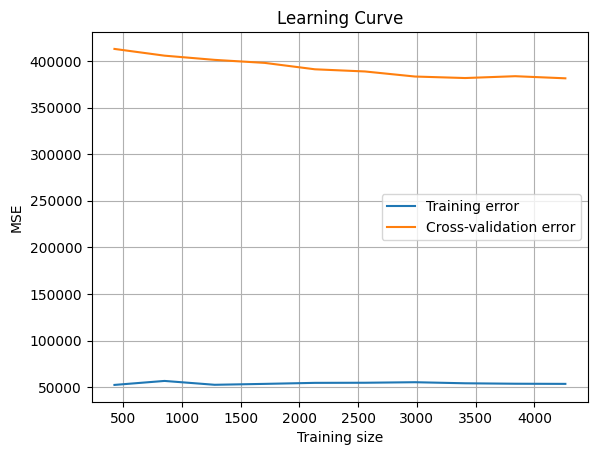

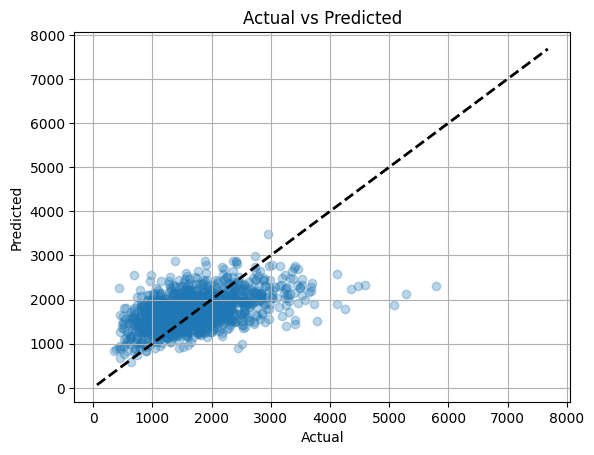

Total script runtime: 1119.249303817749 seconds


In [3]:
import pandas as pd
import json
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import time

# Start timing the script
start_time = time.time()

# Load data from the JSON file
data = []
with open('clean_trips.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to calculate cumulative distance
def calculate_cumulative_distance(lats, lngs):
    cumulative_distance = [0.0]
    for i in range(1, len(lats)):
        start = (lats[i-1], lngs[i-1])
        end = (lats[i], lngs[i])
        dist = geodesic(start, end).kilometers
        cumulative_distance.append(cumulative_distance[-1] + dist)
    return cumulative_distance

# Function to calculate segmented speeds
def calculate_segmented_speeds(cumulative_distance, time_gap):
    speeds = []
    for i in range(1, len(cumulative_distance)):
        distance_diff = cumulative_distance[i] - cumulative_distance[i-1]
        time_diff = time_gap[i] - time_gap[i-1]
        if time_diff != 0:
            speed = distance_diff / (time_diff / 3600)  # speed in km/h
        else:
            speed = 0  # or some other handling mechanism
        speeds.append(speed)
    speeds.insert(0, 0.0)  # Insert 0.0 speed for the first element as there's no previous segment
    return speeds

# Function to find indices with zero time differences
def find_zero_time_diff_indices(time_gap):
    time_diffs = np.diff(time_gap)
    zero_diff_indices = np.where(time_diffs == 0)[0]  # Get indices where time_diff is zero
    return zero_diff_indices.tolist()

# Apply feature engineering
def feature_engineering(df):
    df['cumulative_distance'] = df.apply(lambda row: calculate_cumulative_distance(row['lats'], row['lngs']), axis=1)
    df['segmented_speeds'] = df.apply(lambda row: calculate_segmented_speeds(row['cumulative_distance'], row['time_gap']), axis=1)
    df['zero_time_diff_indices'] = df['time_gap'].apply(find_zero_time_diff_indices)
    
    # Extracting statistical features from lists
    df['avg_segmented_speed'] = df['segmented_speeds'].apply(np.mean)
    df['max_segmented_speed'] = df['segmented_speeds'].apply(np.max)
    df['min_segmented_speed'] = df['segmented_speeds'].apply(np.min)
    df['std_segmented_speed'] = df['segmented_speeds'].apply(np.std)
    
    df['avg_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.mean(np.diff(x)))
    df['max_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.max(np.diff(x)))
    df['min_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.min(np.diff(x)))
    df['std_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.std(np.diff(x)))
    
    df['time_of_day'] = df['timeID'] // 60  # Convert minutes to hours
    df['day_of_week'] = df['dateID'] % 7
    
    # Calculate average speed over the entire trip
    df['average_speed'] = df['dist'] / (df['time'] / 3600)  # speed in km/h
    
    return df

df = feature_engineering(df)

# Define features and target variable
features = [
    'avg_segmented_speed', 'max_segmented_speed', 'min_segmented_speed', 'std_segmented_speed',
    'avg_distance_diff', 'max_distance_diff', 'min_distance_diff', 'std_distance_diff',
    'time_of_day', 'day_of_week', 'average_speed'
]
X = df[features]
y = df['time']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the model with specified hyperparameters
rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    random_state=42,
    criterion='squared_error'
)

# Train the model
rfr.fit(X_train, y_train)

# Predict on the test set
y_pred = rfr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Select an example from the test set for prediction
example_index = X_test[0]
example_y_true = y_test.iloc[0]
example_trip_id = df.iloc[y_test.index[0]].trip_id

# Make prediction
example_y_pred = rfr.predict([example_index])[0]

print(f'Example trip ID: {example_trip_id}')
print(f'Predicted ETA: {example_y_pred}')
print(f'Actual ETA: {example_y_true}')

# Plotting the learning curve
train_sizes, train_scores, test_scores = learning_curve(rfr, X_scaled, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting actual vs predicted values
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# End timing the script
end_time = time.time()
print(f'Total script runtime: {end_time - start_time} seconds')


Mean Absolute Error (MAE): 469.779640630855
Root Mean Squared Error (RMSE): 605.2102669470819
R-squared (R2): 0.2551167790682901
Example trip ID: c565ddbb674fb8382bae1fbbcc47d7bdf6e33d91c8eb0beda3fddbb2c6074640
Predicted ETA: 1760.6258951976642
Actual ETA: 1036.0


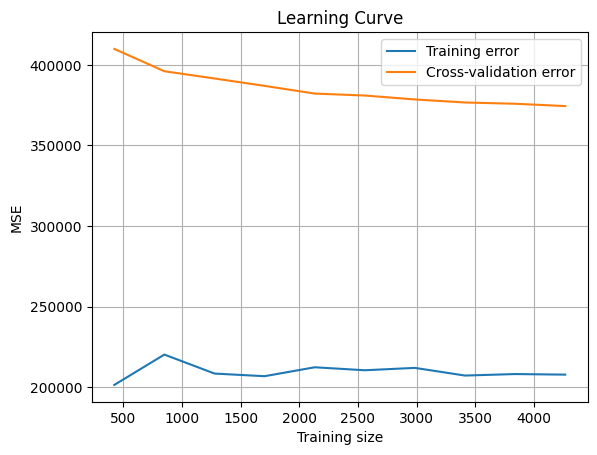

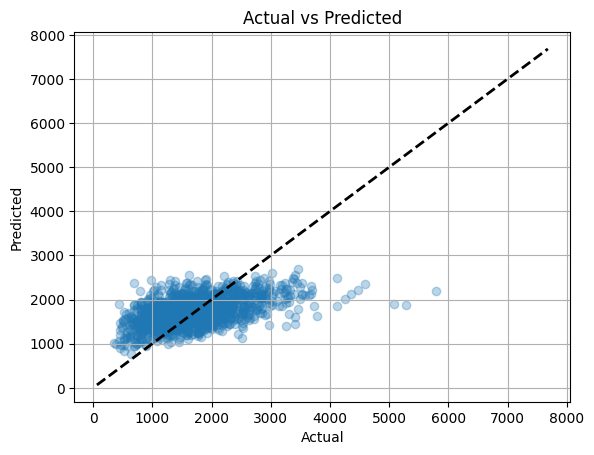

Total script runtime: 760.7571749687195 seconds


In [4]:
import pandas as pd
import json
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import time

# Start timing the script
start_time = time.time()

# Load data from the JSON file
data = []
with open('clean_trips.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Function to calculate cumulative distance
def calculate_cumulative_distance(lats, lngs):
    cumulative_distance = [0.0]
    for i in range(1, len(lats)):
        start = (lats[i-1], lngs[i-1])
        end = (lats[i], lngs[i])
        dist = geodesic(start, end).kilometers
        cumulative_distance.append(cumulative_distance[-1] + dist)
    return cumulative_distance

# Function to calculate segmented speeds
def calculate_segmented_speeds(cumulative_distance, time_gap):
    speeds = []
    for i in range(1, len(cumulative_distance)):
        distance_diff = cumulative_distance[i] - cumulative_distance[i-1]
        time_diff = time_gap[i] - time_gap[i-1]
        if time_diff != 0:
            speed = distance_diff / (time_diff / 3600)  # speed in km/h
        else:
            speed = 0  # or some other handling mechanism
        speeds.append(speed)
    speeds.insert(0, 0.0)  # Insert 0.0 speed for the first element as there's no previous segment
    return speeds

# Function to find indices with zero time differences
def find_zero_time_diff_indices(time_gap):
    time_diffs = np.diff(time_gap)
    zero_diff_indices = np.where(time_diffs == 0)[0]  # Get indices where time_diff is zero
    return zero_diff_indices.tolist()

# Apply feature engineering
def feature_engineering(df):
    df['cumulative_distance'] = df.apply(lambda row: calculate_cumulative_distance(row['lats'], row['lngs']), axis=1)
    df['segmented_speeds'] = df.apply(lambda row: calculate_segmented_speeds(row['cumulative_distance'], row['time_gap']), axis=1)
    df['zero_time_diff_indices'] = df['time_gap'].apply(find_zero_time_diff_indices)
    
    # Extracting statistical features from lists
    df['avg_segmented_speed'] = df['segmented_speeds'].apply(np.mean)
    df['max_segmented_speed'] = df['segmented_speeds'].apply(np.max)
    df['min_segmented_speed'] = df['segmented_speeds'].apply(np.min)
    df['std_segmented_speed'] = df['segmented_speeds'].apply(np.std)
    
    df['avg_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.mean(np.diff(x)))
    df['max_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.max(np.diff(x)))
    df['min_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.min(np.diff(x)))
    df['std_distance_diff'] = df['cumulative_distance'].apply(lambda x: np.std(np.diff(x)))
    
    df['time_of_day'] = df['timeID'] // 60  # Convert minutes to hours
    df['day_of_week'] = df['dateID'] % 7
    
    # Calculate average speed over the entire trip
    df['average_speed'] = df['dist'] / (df['time'] / 3600)  # speed in km/h
    
    return df

df = feature_engineering(df)

# Define features and target variable
features = [
    'avg_segmented_speed', 'max_segmented_speed', 'min_segmented_speed', 'std_segmented_speed',
    'avg_distance_diff', 'max_distance_diff', 'min_distance_diff', 'std_distance_diff',
    'time_of_day', 'day_of_week', 'average_speed'
]
X = df[features]
y = df['time']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the model with optimized hyperparameters
rfr = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    criterion='squared_error'
)

# Train the model
rfr.fit(X_train, y_train)

# Predict on the test set
y_pred = rfr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Select an example from the test set for prediction
example_index = X_test[0]
example_y_true = y_test.iloc[0]
example_trip_id = df.iloc[y_test.index[0]].trip_id

# Make prediction
example_y_pred = rfr.predict([example_index])[0]

print(f'Example trip ID: {example_trip_id}')
print(f'Predicted ETA: {example_y_pred}')
print(f'Actual ETA: {example_y_true}')

# Plotting the learning curve
train_sizes, train_scores, test_scores = learning_curve(rfr, X_scaled, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation error')
plt.xlabel('Training size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting actual vs predicted values
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# End timing the script
end_time = time.time()
print(f'Total script runtime: {end_time - start_time} seconds')
